In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch

from network import Net
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)


Text(0.5, 0, 'Time (s)')

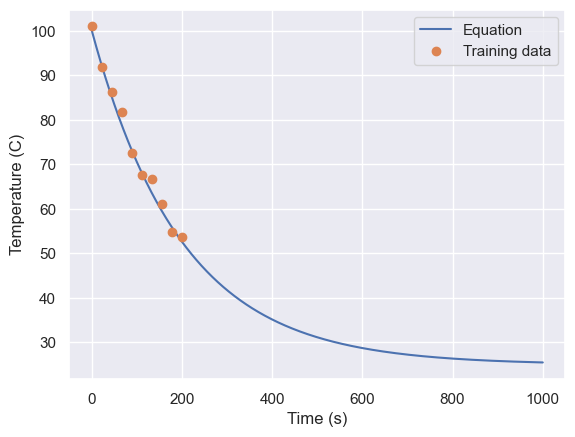

In [2]:
np.random.seed(42)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 200, 10)
y = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, y, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# Vanilla Network

Epoch 0/10000, loss: 5787.50
Epoch 1000/10000, loss: 2288.55
Epoch 2000/10000, loss: 1485.70
Epoch 3000/10000, loss: 579.84
Epoch 4000/10000, loss: 37.22
Epoch 5000/10000, loss: 1.95
Epoch 6000/10000, loss: 1.60
Epoch 7000/10000, loss: 1.56
Epoch 8000/10000, loss: 1.49
Epoch 9000/10000, loss: 1.74


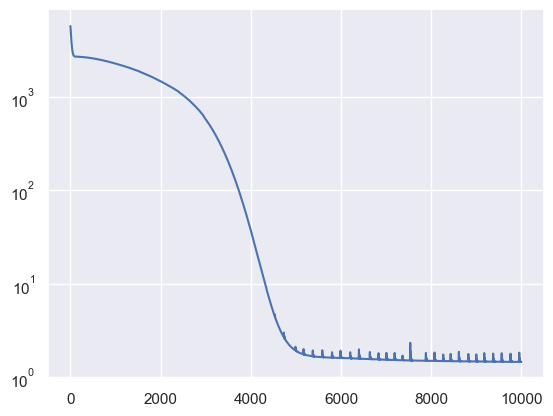

In [3]:
net = Net(1,1, loss2=None, epochs=10000, lr=1e-4).to(DEVICE)

losses = net.fit(t, y)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

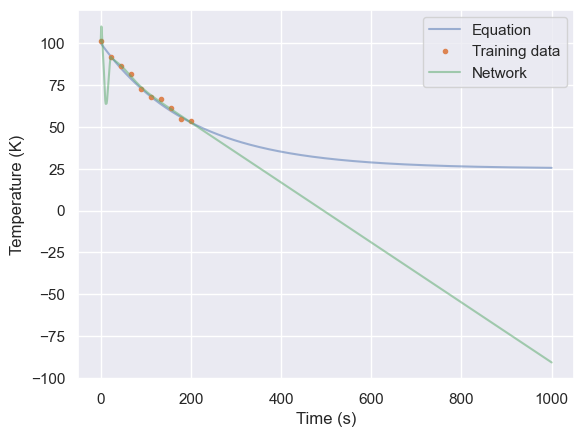

In [4]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

# Standard L2 Regularisation

In [5]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/10000, loss: 6450.12
Epoch 1000/10000, loss: 578.54
Epoch 2000/10000, loss: 356.67
Epoch 3000/10000, loss: 298.80
Epoch 4000/10000, loss: 264.05
Epoch 5000/10000, loss: 236.38
Epoch 6000/10000, loss: 213.04
Epoch 7000/10000, loss: 194.22
Epoch 8000/10000, loss: 180.39
Epoch 9000/10000, loss: 170.17


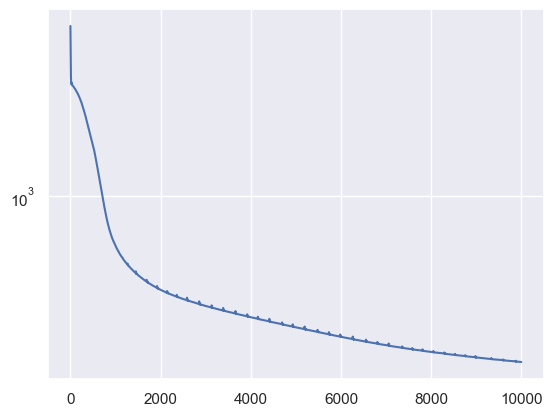

In [6]:
net = Net(1,1, loss2=l2_reg, epochs=10000, lr=5e-4, loss2_weight=0.1).to(DEVICE)

losses = net.fit(t, y)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

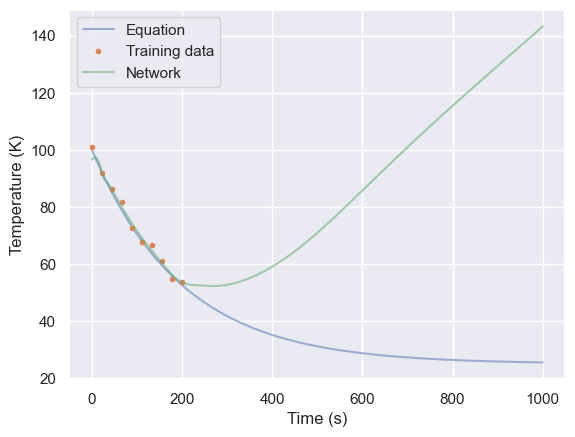

In [7]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

# PINN

In [13]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 7298.26
Epoch 3000/30000, loss: 3026.32
Epoch 6000/30000, loss: 162.67
Epoch 9000/30000, loss: 10.29
Epoch 12000/30000, loss: 3.90
Epoch 15000/30000, loss: 2.44
Epoch 18000/30000, loss: 1.77
Epoch 21000/30000, loss: 1.45
Epoch 24000/30000, loss: 1.30
Epoch 27000/30000, loss: 1.22


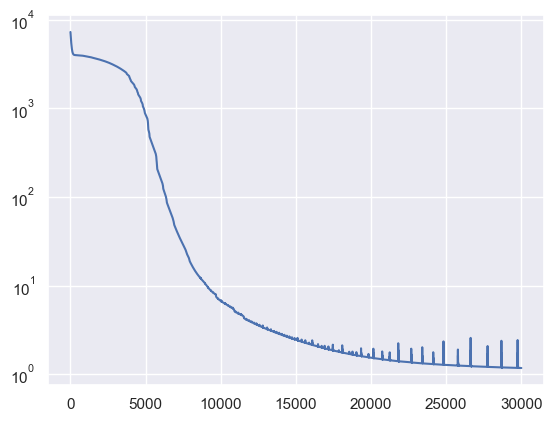

In [31]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1000, lr=3e-5).to(DEVICE)

losses = net.fit(t, y)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

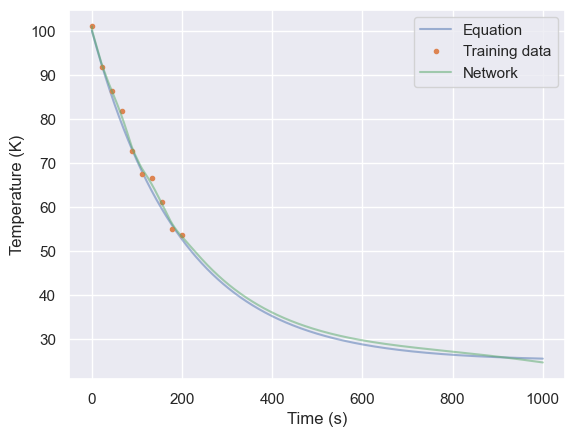

In [32]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')